In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
import spacy
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import hashlib
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from collections import Counter

In [3]:
from sentence_transformers import SentenceTransformer
from bertopic import BERTopic
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic.vectorizers import ClassTfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

/Users/jinzi/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# load data
tiktok_comments_df_0212 = pd.read_csv('tiktok_comments_20250212.csv')
tiktok_comments_df_0712 = pd.read_csv('tiktok_comments_0712.csv')
tiktok_videos_df_0212 = pd.read_csv('tiktok_videos_20250212.csv')
tiktok_videos_df_0712 = pd.read_csv('tiktok_videos_0712.csv')

In [5]:
tiktok_comments_df = pd.concat([tiktok_comments_df_0212, tiktok_comments_df_0712], ignore_index=True)
tiktok_comments_df = tiktok_comments_df.drop_duplicates(subset=["comment_id"])
tiktok_videos_df = pd.concat([tiktok_videos_df_0212, tiktok_videos_df_0712], ignore_index=True)
tiktok_videos_df = tiktok_videos_df.drop_duplicates(subset=["video_id"])
tiktok_comments_df.to_csv("tiktok_comments_all.csv", index=False)
tiktok_videos_df.to_csv("tiktok_videos_all.csv", index=False)
print(f"- number of comments {len(tiktok_comments_df)}")
print(f"- number of videos {len(tiktok_videos_df)}")

- number of comments 65256
- number of videos 2005


# data preprocessing

## change datetime

In [6]:
tiktok_videos_df['create_time'] = pd.to_datetime(tiktok_videos_df['create_time'], unit='s')
tiktok_comments_df['create_time'] = pd.to_datetime(tiktok_comments_df['create_time'], unit='s')

In [17]:
tiktok_comments_df

,video_id,comment_id,text,like_count,reply_count,parent_comment_id,create_time
0,7415010529938312491,7415316469133787947,why did it make my features seem so close in t...,546,6,7415010529938312491,2024-09-16 18:55:47
1,7415010529938312491,7415014499361899295,My eyes are so crooked goodnight,330,2,7415010529938312491,2024-09-15 23:23:28
2,7415010529938312491,7415298164858651434,Just tried it and now I have to put myself to ...,245,0,7415010529938312491,2024-09-16 17:44:34
3,7415010529938312491,7415066069038039850,mine made me look like a literal alien cat cre...,95,1,7415010529938312491,2024-09-16 02:43:52
4,7415010529938312491,7415012763640480543,no bc i hate it 😂😂 i looked at myself and had ...,37,0,7415010529938312491,2024-09-15 23:16:41
...,...,...,...,...,...,...,...
70645,7519874634645261574,7520772535500784406,Yo lo oí por primera vez a Samantha Hudson 🥺 t...,1,0,7519874634645261574,2025-06-27 23:18:55
70646,7519850618253528351,7519851014679577374,please forgive me for pasting the title in the...,0,0,7519850618253528351,2025-06-25 11:44:23
70647,7519845763011120406,7519875225455575830,MY JAW DROPPED THATS AMAZING,1,1,7519845763011120406,2025-06-25 13:16:42
70648,7519845763011120406,7519868516221993750,This needs more likes,2,1,7519845763011120406,2025-06-25 12:50:42


In [18]:
tiktok_videos_df

,video_id,username,create_time,region_code,video_description,view_count,like_count,comment_count,share_count,video_duration,hashtag_names,video_url
0,7415010529938312491,aphantasiaindigo,2024-09-15 23:08:00,US,Put me to sleep dude #viral #fyp #aphantasiain...,197093,9271,179,122,10,"viral,fyp,aphantasiaindigo",https://www.tiktok.com/@aphantasiaindigo/video...
1,7415005163548724486,sowls_s,2024-09-15 22:47:17,BR,watch til the end... #synesthesia #aphantasia ...,180684,4023,626,721,0,"fy,innermonologue,synesthesia,aphantasia",https://www.tiktok.com/@sowls_s/video/74150051...
2,7414985496369106207,cjwhitt77,2024-09-15 21:30:58,US,Replying to @aphantasia_mania #autism #disabil...,340,43,6,0,81,"kids,parents,autism,disability",https://www.tiktok.com/@cjwhitt77/video/741498...
3,7414949250422918430,eclectic_ideations,2024-09-15 19:10:19,US,i feel cursed #real #vent #trauma #mentalhealt...,1597,119,14,7,12,"real,trauma,autism,mentalillness,mentalhealth,...",https://www.tiktok.com/@eclectic_ideations/vid...
4,7414851230142369030,pondernesia,2024-09-15 12:49:52,ID,Aphantasia adalah kondisi di mana seseorang ti...,83960,2200,121,133,0,"sains,psikologi,pengetahuan,aphantasia",https://www.tiktok.com/@pondernesia/video/7414...
...,...,...,...,...,...,...,...,...,...,...,...,...
2000,7519640671980948767,onebrilliantarc,2025-06-24 22:06:27,us,The golden rule of writing is also one of the ...,0,0,2,0,86,"writerproblems,writingtips,writersoftiktok,wri...",https://www.tiktok.com/@onebrilliantarc/video/...
2001,7519625587204328717,crystabellaunfiltered,2025-06-24 21:08:23,us,Can you see what your thinking about? Because ...,0,0,28,0,22,"viral,mindblown,thirdeye,fyp,countingsheep,min...",https://www.tiktok.com/@crystabellaunfiltered/...
2002,7519619873987628318,justpinkyvibes,2025-06-24 20:45:56,us,#JustPinkyVibes 💗🩷💖 Fangirl post y’all! I’m a ...,0,0,0,0,221,"trending,austintexas,brujas,keepaustinweird,me...",https://www.tiktok.com/@justpinkyvibes/video/7...
2003,7519573084106411294,empowerapothecary,2025-06-24 17:44:25,us,✨POV: You're a witch with aphantasia Visualiza...,0,0,1,0,27,"everydaymagic,manifestation,aphantasia,witchto...",https://www.tiktok.com/@empowerapothecary/vide...


## Tokenization

In [7]:
nltk.download('punkt_tab')
nltk.download("stopwords")
# Loda Spacy
nlp = spacy.load("en_core_web_sm")

[nltk_data] Downloading package punkt_tab to /Users/jinzi/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/jinzi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
#  stopwords
tiktok_stopwords = {
    "lol", "idk", "pls", "tbh", "smh", "lmao", "omg",
    "fyp", "viral", "booktok", "aphantasiaindigo",  # 平台标签 / 用户名
    "t", "ve", "re", "d", "m", "ll", "s", "im", "dont", "cant", "didnt",
    "also", "would", "think", "people", "get", "go", "like", "just",
    "know", "thing", "things", "really", "not", "do", "can"
}

stop_words = set(stopwords.words("english")).union(tiktok_stopwords)

def clean_and_tokenize(text):
    if not isinstance(text, str):
        return []
    
    # 1. Turn lowercase
    text = text.lower()

    # 2. Remove non-alphanumeric characters
    text = re.sub(r"[^a-z0-9\s]", "", text)

    # 3. tokenize
    tokens = word_tokenize(text)

    # 4. remove stopwords
    tokens = [token for token in tokens if token not in stop_words]

    # 5. lemmatize
    doc = nlp(" ".join(tokens))
    lemmas = [tok.lemma_ for tok in doc if tok.lemma_ not in stop_words and len(tok.lemma_) > 2]

    return lemmas

In [9]:
tiktok_videos_df["video_description_tokens"] = tiktok_videos_df["video_description"].apply(clean_and_tokenize)
tiktok_comments_df["comment_text_tokens"] = tiktok_comments_df["text"].apply(clean_and_tokenize)

# EDA

## basic info

In [24]:
total_videos = tiktok_videos_df['video_id'].nunique()
total_comments = len(tiktok_comments_df)

# 初始化统计
hashtag_stats = {"aphantasia": {"videos": 0, "comments": 0},
                 "hyperphantasia": {"videos": 0, "comments": 0}}

# 统计视频数
for _, row in tiktok_videos_df.iterrows():
    tags_lower = [t.strip().lower() for t in str(row['hashtag_names']).split(',')]
    for key in hashtag_stats.keys():
        if key in tags_lower:
            hashtag_stats[key]["videos"] += 1
            # 统计该视频的评论数
            vid = row["video_id"]
            comment_count = tiktok_comments_df[tiktok_comments_df["video_id"] == vid].shape[0]
            hashtag_stats[key]["comments"] += comment_count

# 打印结果
print("=== Basic statistics ===")
print(f"Total number of videos: {total_videos}")
print(f"Total number of comments: {total_comments}")
print("Distribution of tags:")
for tag, stat in hashtag_stats.items():
    print(f"  {tag}:  number of videos = {stat['videos']}, number of comments = {stat['comments']}")


=== Basic statistics ===
Total number of videos: 2005
Total number of comments: 65256
Distribution of tags:
  aphantasia:  number of videos = 1182, number of comments = 35759
  hyperphantasia:  number of videos = 147, number of comments = 4868


          Hashtag  Video Count  Comment Count
0      aphantasia         1182          35759
1  hyperphantasia          147           4868


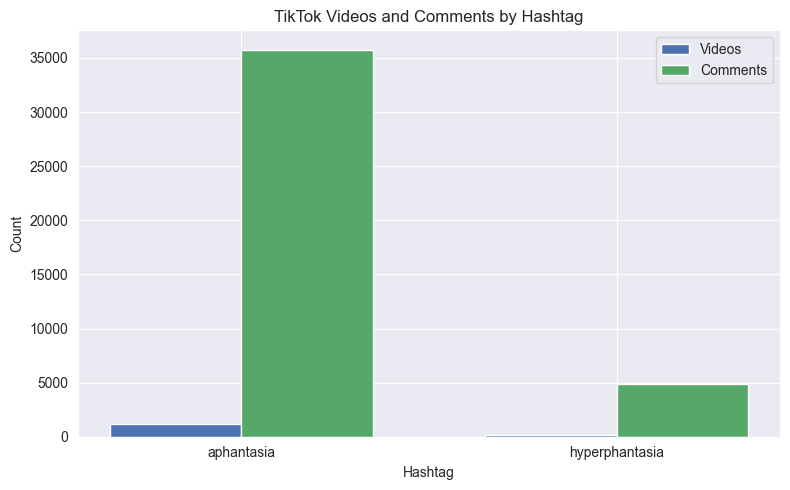

In [25]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === 统计部分 ===
total_videos = tiktok_videos_df['video_id'].nunique()
total_comments = len(tiktok_comments_df)

# 初始化统计
hashtag_stats = {"aphantasia": {"videos": 0, "comments": 0},
                 "hyperphantasia": {"videos": 0, "comments": 0}}

# 统计每个 hashtag 对应的视频数和评论数
for _, row in tiktok_videos_df.iterrows():
    tags_lower = [t.strip().lower() for t in str(row['hashtag_names']).split(',')]
    for key in hashtag_stats.keys():
        if key in tags_lower:
            hashtag_stats[key]["videos"] += 1
            vid = row["video_id"]
            comment_count = tiktok_comments_df[tiktok_comments_df["video_id"] == vid].shape[0]
            hashtag_stats[key]["comments"] += comment_count

# 转成 DataFrame
hashtag_df = pd.DataFrame([
    {"Hashtag": tag, "Video Count": stat["videos"], "Comment Count": stat["comments"]}
    for tag, stat in hashtag_stats.items()
])

print(hashtag_df)

# === 绘图部分 ===
x = np.arange(len(hashtag_df))  # 横坐标位置
width = 0.35  # 柱宽

plt.figure(figsize=(8,5))
plt.bar(x - width/2, hashtag_df["Video Count"], width, label="Videos", color="#4C72B0")
plt.bar(x + width/2, hashtag_df["Comment Count"], width, label="Comments", color="#55A868")

plt.xticks(x, hashtag_df["Hashtag"])
plt.title("TikTok Videos and Comments by Hashtag")
plt.xlabel("Hashtag")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [22]:
tiktok_videos_df.describe()

,video_id,create_time,view_count,like_count,comment_count,share_count,video_duration
count,2.005000e+03,2005,2.005000e+03,2005.000000,2005.000000,2005.000000,2005.000000
mean,7.471418e+18,2025-02-15 00:04:26.910723072,3.422876e+04,3039.577556,103.536160,244.616459,68.369077
min,7.403928e+18,2024-08-17 02:22:56,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,7.444552e+18,2024-12-04 13:43:26,3.190000e+02,10.000000,1.000000,0.000000,12.000000
50%,7.474894e+18,2025-02-24 08:07:41,6.910000e+02,34.000000,6.000000,1.000000,36.000000
75%,7.500438e+18,2025-05-04 04:09:55,3.685000e+03,182.000000,22.000000,6.000000,80.000000
max,7.526305e+18,2025-07-12 21:06:22,6.532122e+06,645355.000000,27396.000000,67773.000000,1307.000000
std,3.403383e+16,NaN,2.882930e+05,26612.359453,889.916144,2593.433902,100.975879


In [23]:
tiktok_comments_df.describe()

,video_id,comment_id,like_count,reply_count,parent_comment_id,create_time
count,6.525600e+04,6.525600e+04,65256.000000,65256.000000,6.525600e+04,65256
mean,7.459983e+18,7.466385e+18,31.485963,0.493610,7.459983e+18,2025-02-01 09:48:24.569465088
min,7.403947e+18,7.404092e+18,0.000000,0.000000,7.403947e+18,2024-08-17 13:01:08
25%,7.439564e+18,7.441361e+18,0.000000,0.000000,7.439564e+18,2024-11-25 23:20:19
50%,7.451114e+18,7.467788e+18,0.000000,0.000000,7.451114e+18,2025-02-05 04:30:36.500000
75%,7.488041e+18,7.494997e+18,1.000000,0.000000,7.488041e+18,2025-04-19 12:14:52.249999872
max,7.526305e+18,7.540322e+18,86033.000000,237.000000,7.526305e+18,2025-08-19 15:39:37
std,3.147868e+16,3.283197e+16,864.707438,3.647374,3.147868e+16,NaN


In [24]:
tiktok_videos_df.apply(lambda x: sum(x.isnull()),axis=0)

video_id               0
username               0
create_time            0
region_code            0
video_description      0
view_count             0
like_count             0
comment_count          0
share_count            0
video_duration         0
hashtag_names        109
video_url              0
dtype: int64

In [25]:
tiktok_comments_df.apply(lambda x: sum(x.isnull()),axis=0)

video_id               0
comment_id             0
text                 100
like_count             0
reply_count            0
parent_comment_id      0
create_time            0
dtype: int64

In [26]:
tiktok_comments_df = tiktok_comments_df.dropna(subset=["text"])

tiktok_comments_df = tiktok_comments_df.reset_index(drop=True)

print("new cleaned tiktok comments", len(tiktok_comments_df))

new cleaned tiktok comments 65156


In [154]:
# 每条评论的词数（按空格分词）
tiktok_comments_df["text_length_word"] = tiktok_comments_df["text"].astype(str).apply(lambda x: len(x.split()))

# 平均长度
avg_word_len = tiktok_comments_df["text_length_word"].mean()
print(f"平均评论长度（按词数）：{avg_word_len:.2f}")

平均评论长度（按词数）：13.48


## 相关系数

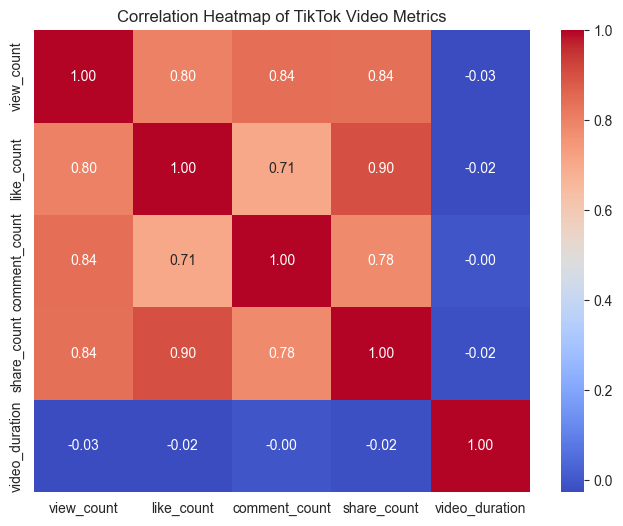

In [32]:
cols = ["view_count", "like_count", "comment_count", "share_count", "video_duration"]
corr = tiktok_videos_df[cols].corr()  # 计算相关系数矩阵

# 绘制热力图
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of TikTok Video Metrics")
plt.show()

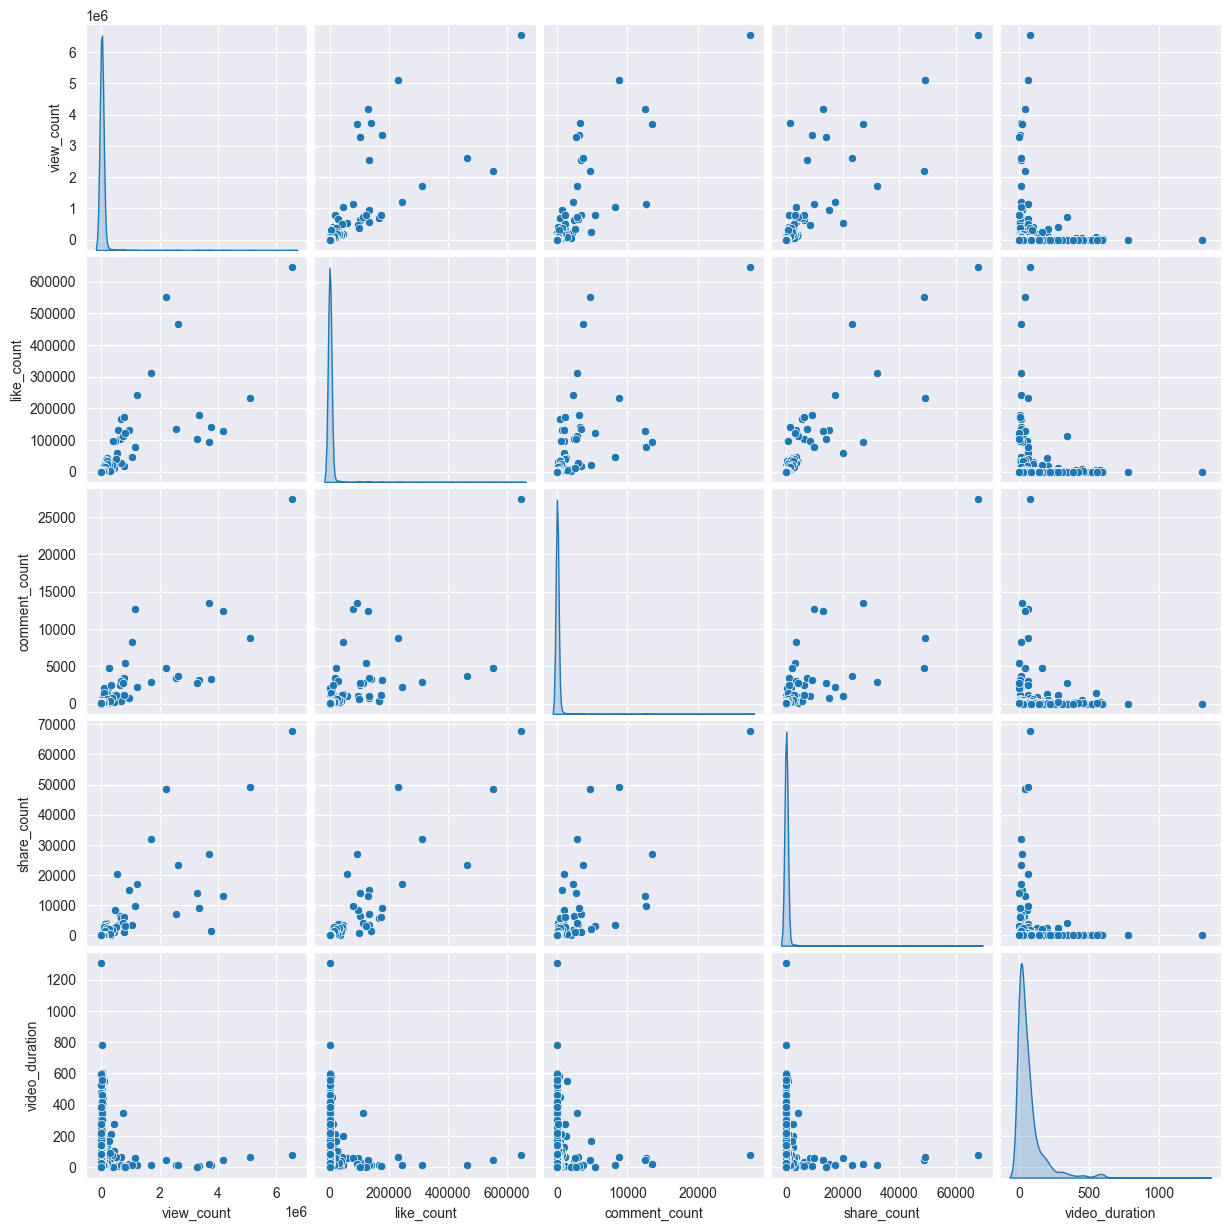

In [33]:
sns.pairplot(tiktok_videos_df[cols], diag_kind="kde")
plt.show()


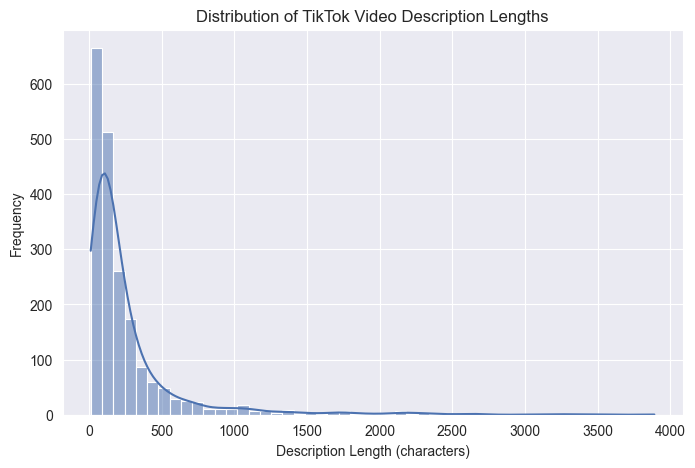

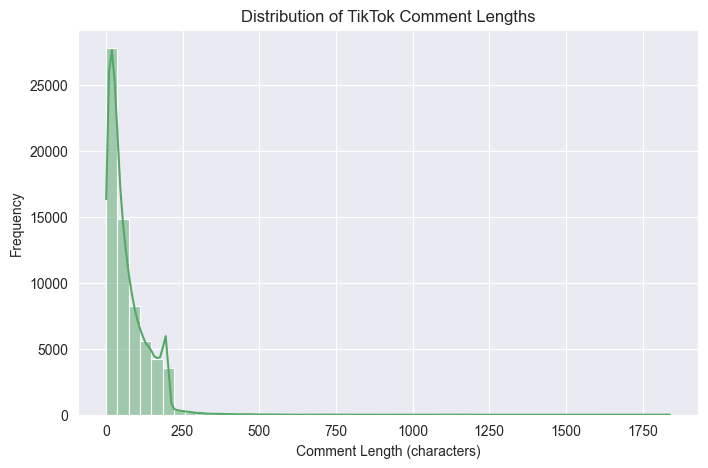

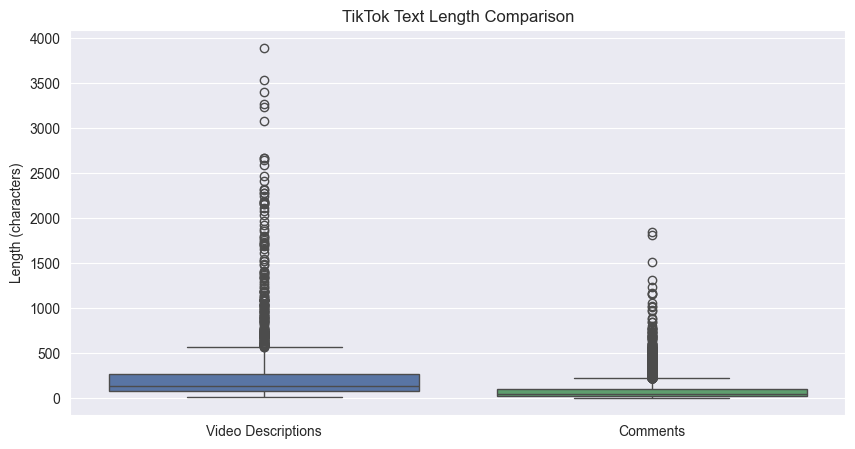

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

# 视频文案长度
tiktok_videos_df["description_length"] = tiktok_videos_df["video_description"].fillna("").apply(len)

# 评论长度
tiktok_comments_df["comment_length"] = tiktok_comments_df["text"].fillna("").apply(len)

# --- 视频文案长度分布 ---
plt.figure(figsize=(8,5))
sns.histplot(tiktok_videos_df["description_length"], bins=50, kde=True, color="#4C72B0")
plt.title("Distribution of TikTok Video Description Lengths")
plt.xlabel("Description Length (characters)")
plt.ylabel("Frequency")
plt.show()

# --- 评论长度分布 ---
plt.figure(figsize=(8,5))
sns.histplot(tiktok_comments_df["comment_length"], bins=50, kde=True, color="#55A868")
plt.title("Distribution of TikTok Comment Lengths")
plt.xlabel("Comment Length (characters)")
plt.ylabel("Frequency")
plt.show()

# --- 箱线图比较 ---
plt.figure(figsize=(10,5))
sns.boxplot(data=[tiktok_videos_df["description_length"], tiktok_comments_df["comment_length"]],
            palette=["#4C72B0", "#55A868"])
plt.xticks([0,1], ["Video Descriptions", "Comments"])
plt.title("TikTok Text Length Comparison")
plt.ylabel("Length (characters)")
plt.show()


## Tags of videos

In [19]:
all_tags = (
    tiktok_videos_df['hashtag_names']
    .dropna()
    .apply(lambda x: [t.strip().lower() for t in str(x).split(',') if t.strip()])
    .explode()
)
# Statistics of occurrences
tag_counts = all_tags.value_counts().reset_index()
tag_counts.columns = ['tag', 'count']

print(tag_counts.head(30))

                    tag  count
0            aphantasia   1182
1                   fyp    634
2                 viral    291
3      aphantasiaindigo    262
4               booktok    189
5        hyperphantasia    147
6                   art    132
7                artist    107
8            psychology     86
9        neurodivergent     85
10           foryoupage     84
11               foryou     75
12             mindseye     74
13          imagination     74
14              drawing     67
15        visualization     63
16         mentalhealth     61
17                 adhd     55
18  aphantasiaawareness     55
19              reading     54
20               stitch     53
21                 fypシ     47
22            indierock     46
23     aphantasiaartist     45
24             indiepop     44
25         neuroscience     44
26      artistsoftiktok     43
27               autism     42
28                books     41
29       aphantasiagang     38


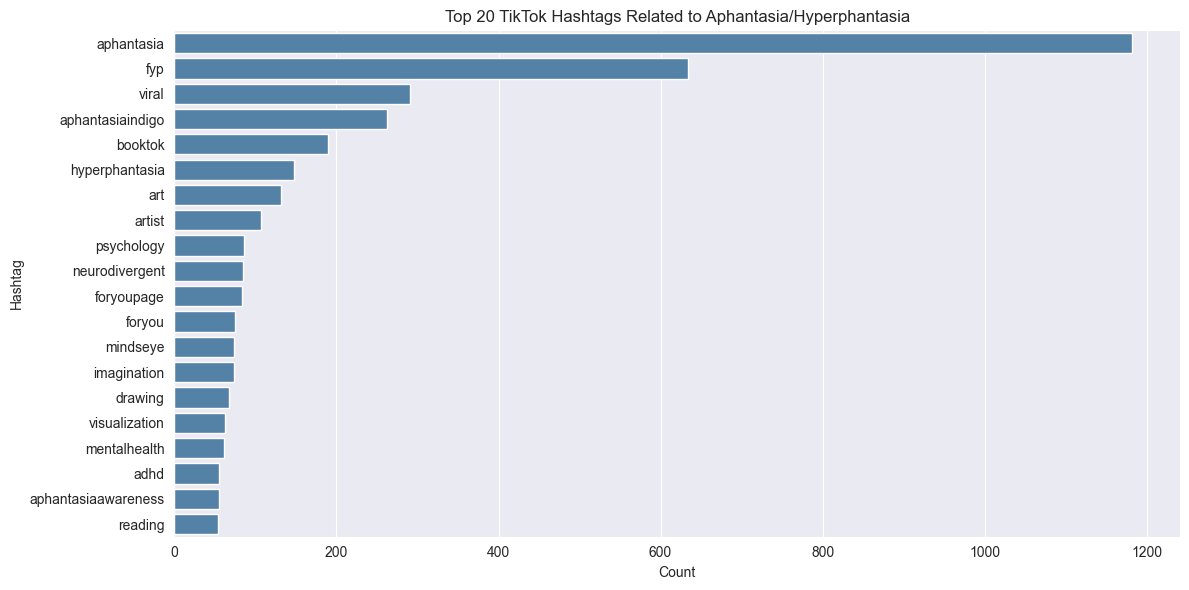

In [31]:
top_tags = tag_counts.head(20)

plt.figure(figsize=(12, 6))
sns.barplot(x="count", y="tag", data=top_tags, color="steelblue")  # 统一蓝色

plt.title("Top 20 TikTok Hashtags Related to Aphantasia/Hyperphantasia")
plt.xlabel("Count")
plt.ylabel("Hashtag")
plt.tight_layout()
plt.show()

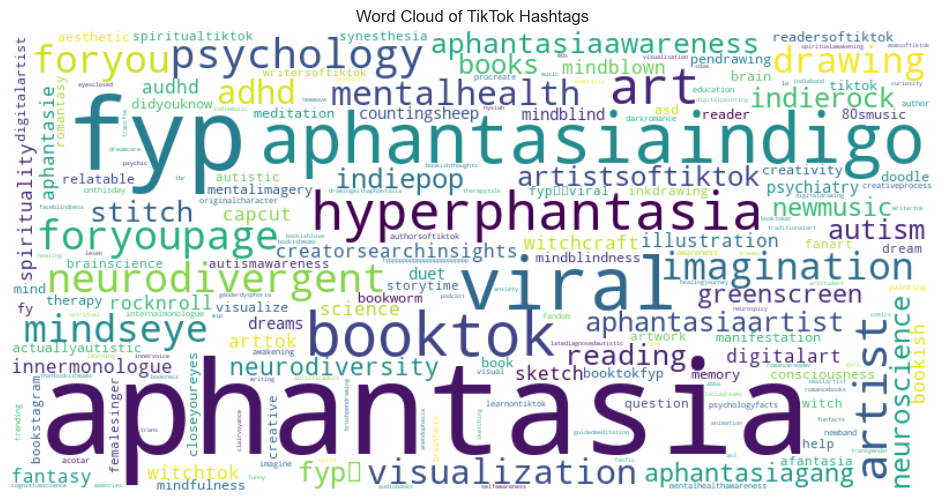

In [30]:
from wordcloud import WordCloud
# 转换成字典形式
tag_dict = dict(zip(tag_counts['tag'], tag_counts['count']))

# 生成词云
wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate_from_frequencies(tag_dict)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of TikTok Hashtags")
plt.show()

## Time Series Analysis

/var/folders/gy/bylk180j7lngr3681t0sd1x00000gn/T/ipykernel_4039/1010949192.py:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  .resample('M')['video_id']


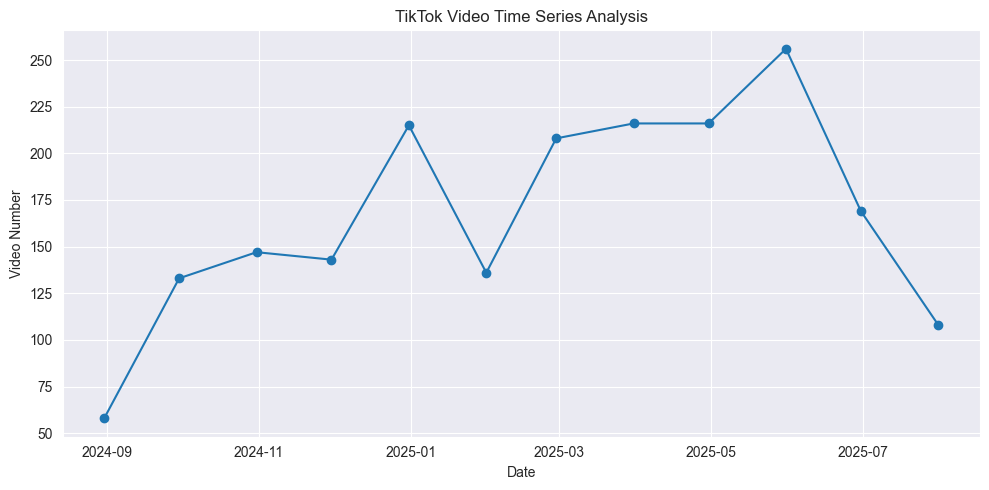

In [21]:
# by month
videos_by_month = (
    tiktok_videos_df
    .set_index('create_time')
    .resample('M')['video_id']
    .nunique()  # 每个月不重复视频数
)

plt.figure(figsize=(10, 5))
plt.plot(videos_by_month.index, videos_by_month.values, marker='o')
plt.title("TikTok Video Time Series Analysis")
plt.xlabel("Date")
plt.ylabel("Video Number")
plt.grid(True)
plt.tight_layout()
plt.show()

## High frequency words

In [52]:
tiktok_token_list = pd.concat([tiktok_videos_df['video_description_tokens'],tiktok_comments_df['comment_text_tokens']]).explode().dropna()
tiktok_word_count = Counter(tiktok_token_list)
print(tiktok_word_count.most_common(20))

[('see', 13621), ('aphantasia', 4635), ('head', 3968), ('eye', 3850), ('picture', 3333), ('imagine', 2934), ('mind', 2914), ('love', 2895), ('read', 2812), ('make', 2704), ('look', 2505), ('feel', 2376), ('movie', 2357), ('dream', 2302), ('time', 2254), ('hear', 2211), ('say', 2167), ('image', 2130), ('apple', 2044), ('visualize', 2035)]


Compare with reddit

In [53]:
reddit_word_count = pd.read_csv('reddit_word_freq.csv')

In [65]:
reddit_word_count_df = reddit_word_count.rename(columns={'count':'reddit_count'})
reddit_word_count_df.head()

,word,reddit_count
0,see,9424
1,feel,5330
2,mind,5250
3,aphantasia,5167
4,imagine,4074


In [70]:
tiktok_word_count_df = pd.DataFrame(tiktok_word_count.most_common(20), columns=['word', 'tiktok_count'])
# merge 2 df into 1
merged_word_count_df = pd.merge(reddit_word_count_df, tiktok_word_count_df, on="word", how="outer").fillna(0)
# turn into integer
merged_word_count_df['reddit_count'] = merged_word_count_df['reddit_count'].astype('int')
merged_word_count_df['tiktok_count'] = merged_word_count_df['tiktok_count'].astype('int')

# add an extra column 'diff'
# merged_word_count_df['diff'] = merged_word_count_df['reddit_count'] - merged_word_count_df['tiktok_count']

# Sort by total frequency
merged_word_count_df['total'] = merged_word_count_df['reddit_count'] + merged_word_count_df['tiktok_count']
merged_word_count_df = merged_word_count_df.sort_values(by='total', ascending=False)

print(merged_word_count_df.head(20))


          word  reddit_count  tiktok_count  total
73         see          9424         13621  23045
6   aphantasia          5167          4635   9802
56        mind          5250          2914   8164
24        feel          5330          2376   7706
23         eye          3662          3850   7512
31        head          3384          3968   7352
39     imagine          4074          2934   7008
36       image          3796          2130   5926
45        look          3225          2505   5730
68        read          2867          2812   5679
19       dream          3059          2302   5361
64     picture          1942          3333   5275
94   visualize          3040          2035   5075
32        hear          2560          2211   4771
53      memory          3758             0   3758
22  experience          3600             0   3600
92      visual          3474             0   3474
7        apple          1335          2044   3379
99        word          3085             0   3085


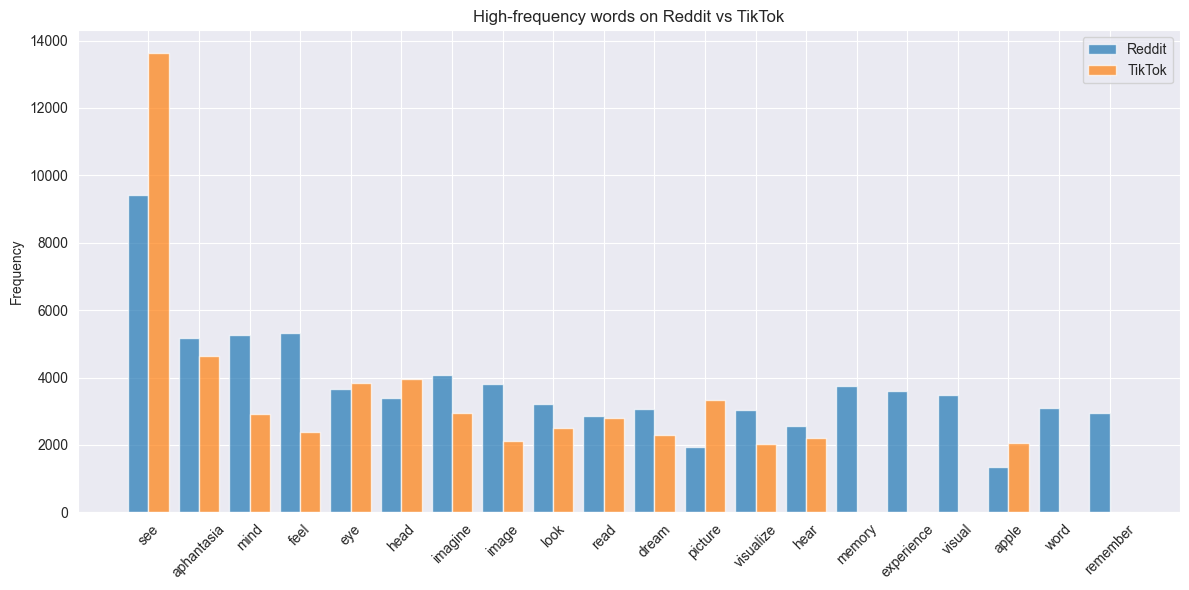

In [67]:
top_words = merged_word_count_df.head(20)  # 只取前15个

bar_width = 0.4
x = range(len(top_words))

plt.figure(figsize=(12,6))
plt.bar(x, top_words["reddit_count"], width=bar_width, label="Reddit", alpha=0.7)
plt.bar([i+bar_width for i in x], top_words["tiktok_count"], width=bar_width, label="TikTok", alpha=0.7)

plt.xticks([i + bar_width/2 for i in x], top_words["word"], rotation=45)
plt.ylabel("Frequency")
plt.title("High-frequency words on Reddit vs TikTok")
plt.legend()
plt.tight_layout()
plt.show()

# topic modeling

## LDA

In [73]:
from gensim import corpora, models
from nltk.corpus import stopwords
import pyLDAvis.gensim_models
import pyLDAvis
from gensim.models import CoherenceModel

In [71]:
print(f"Number of posts: {len(tiktok_token_list)}")

Number of posts: 414726


In [13]:
tiktok_all_docs = pd.concat([tiktok_videos_df['video_description_tokens'],tiktok_comments_df['comment_text_tokens']]).dropna().tolist()
tiktok_video_docs = tiktok_videos_df["video_description_tokens"].dropna().tolist()
tiktok_comment_docs = tiktok_comments_df['comment_text_tokens'].dropna().tolist()

In [109]:
# Create dictionary
dictionary_v = corpora.Dictionary(tiktok_video_docs)
dictionary_c = corpora.Dictionary(tiktok_comment_docs)
# Filter extremes
dictionary_v.filter_extremes(no_below=5, no_above=0.5)
dictionary_c.filter_extremes(no_below=5, no_above=0.5)
# Turn text to bags-of-words
corpus_v = [dictionary_v.doc2bow(text) for text in tiktok_video_docs]
corpus_c = [dictionary_c.doc2bow(text) for text in tiktok_comment_docs]

### video description

Evaluating topics: 100%|██████████| 28/28 [01:25<00:00,  3.04s/it]


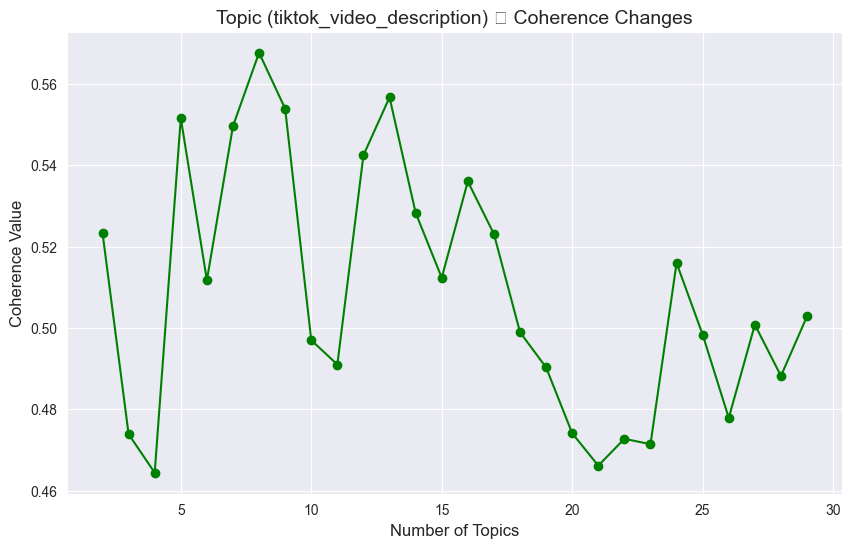

In [111]:
coherences = []
topic_range = list(range(2, 30))
for num_topics in tqdm(topic_range, desc="Evaluating topics"):
    lda_v = models.LdaModel(corpus=corpus_v,
                          id2word=dictionary_v,
                          num_topics=num_topics,
                          random_state=42,
                          passes=10,
                          alpha='auto')

    coherence_model_v = CoherenceModel(model=lda_v, texts=tiktok_video_docs, dictionary=dictionary_v, coherence='c_v')
    score_v = coherence_model_v.get_coherence()
    coherences.append(score_v)

plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherences, marker='o', color='green')
plt.title("Topic (tiktok_video_description) 一 Coherence Changes", fontsize=14)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Value", fontsize=12)
plt.grid(True)
plt.show()

Evaluating topics: 100%|██████████| 28/28 [00:38<00:00,  1.39s/it]


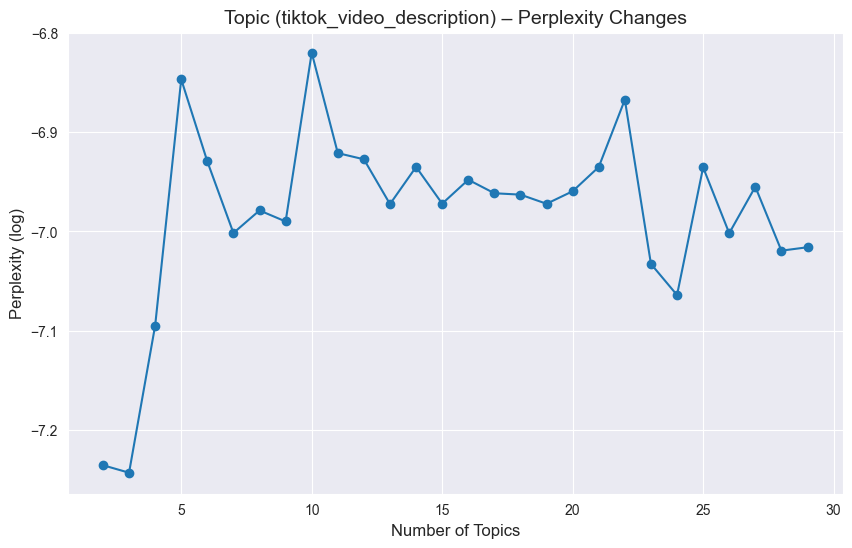

In [112]:
perplexities = []

for num_topics in tqdm(topic_range, desc="Evaluating topics"):
    lda_v = models.LdaModel(corpus=corpus_v, 
                   id2word=dictionary_v, 
                   num_topics=num_topics, 
                   random_state=42, 
                   passes=10, 
                   alpha='auto',
                   per_word_topics=True)
    
    log_perplexity_v = lda_v.log_perplexity(corpus_v)
    perplexities.append(log_perplexity_v)  # 注意：越接近 0 越好（负值）

# 画图
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexities, marker='o')
plt.title("Topic (tiktok_video_description) – Perplexity Changes", fontsize=14)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Perplexity (log)", fontsize=12)
plt.grid(True)
plt.show()

In [106]:
num_topics = 10
# Train LDA
lda_model_v = models.LdaModel(
    corpus=corpus_v,
    id2word=dictionary_v,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [107]:
lda_model_v.print_topics(num_topics, num_words=15)

[(0,
  '0.032*"dream" + 0.030*"time" + 0.022*"remember" + 0.019*"sound" + 0.018*"memory" + 0.018*"aphantasia" + 0.016*"yes" + 0.015*"take" + 0.014*"sometimes" + 0.013*"inner" + 0.012*"monologue" + 0.012*"visual" + 0.011*"different" + 0.011*"every" + 0.009*"come"'),
 (1,
  '0.088*"see" + 0.025*"picture" + 0.024*"head" + 0.022*"imagine" + 0.021*"feel" + 0.020*"eye" + 0.019*"make" + 0.017*"mind" + 0.017*"hear" + 0.017*"say" + 0.016*"look" + 0.016*"apple" + 0.015*"one" + 0.013*"anything" + 0.012*"image"'),
 (2,
  '0.044*"song" + 0.044*"girl" + 0.039*"day" + 0.035*"year" + 0.021*"please" + 0.020*"listen" + 0.018*"beautiful" + 0.016*"old" + 0.014*"baby" + 0.014*"miss" + 0.013*"happy" + 0.012*"sing" + 0.011*"ago" + 0.011*"que" + 0.010*"mais"'),
 (3,
  '0.029*"queen" + 0.027*"man" + 0.021*"die" + 0.021*"mama" + 0.020*"het" + 0.018*"een" + 0.016*"ook" + 0.014*"ich" + 0.014*"non" + 0.013*"smoke" + 0.013*"zie" + 0.011*"heb" + 0.011*"voor" + 0.010*"ring" + 0.010*"niet"'),
 (4,
  '0.066*"thank" + 0

In [120]:
# Visualize Topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_v, corpus_v, dictionary_v)
pyLDAvis.display(vis)

# Save to html files
pyLDAvis.save_html(vis, "tiktok_10_v.html")

### comment

Evaluating topics: 100%|██████████| 28/28 [12:03<00:00, 25.84s/it]


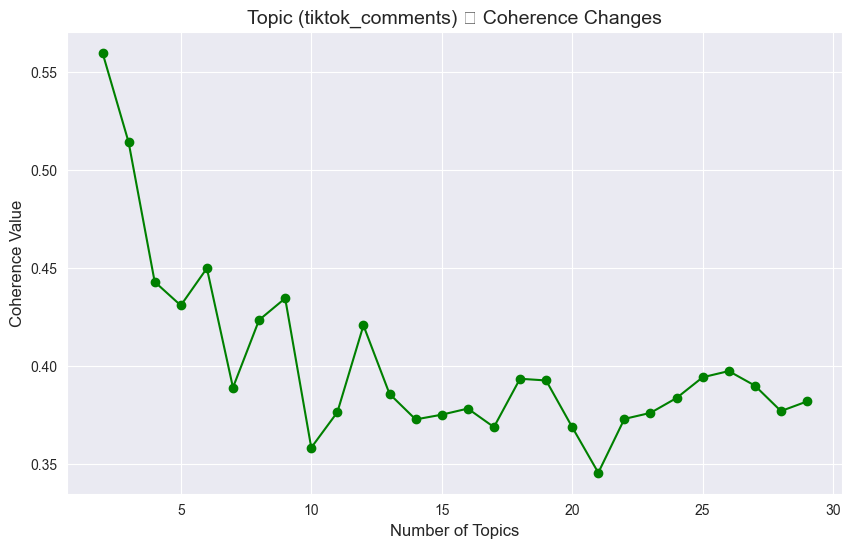

In [114]:
coherences_c = []
topic_range = list(range(2, 30))
for num_topics in tqdm(topic_range, desc="Evaluating topics"):
    lda_c = models.LdaModel(corpus=corpus_c,
                          id2word=dictionary_c,
                          num_topics=num_topics,
                          random_state=42,
                          passes=10,
                          alpha='auto')

    coherence_model_c = CoherenceModel(model=lda_c, texts=tiktok_comment_docs, dictionary=dictionary_c, coherence='c_v')
    score_c = coherence_model_c.get_coherence()
    coherences_c.append(score_c)

plt.figure(figsize=(10, 6))
plt.plot(topic_range, coherences_c, marker='o', color='green')
plt.title("Topic (tiktok_comments) 一 Coherence Changes", fontsize=14)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Coherence Value", fontsize=12)
plt.grid(True)
plt.show()

Evaluating topics: 100%|██████████| 28/28 [11:42<00:00, 25.08s/it]


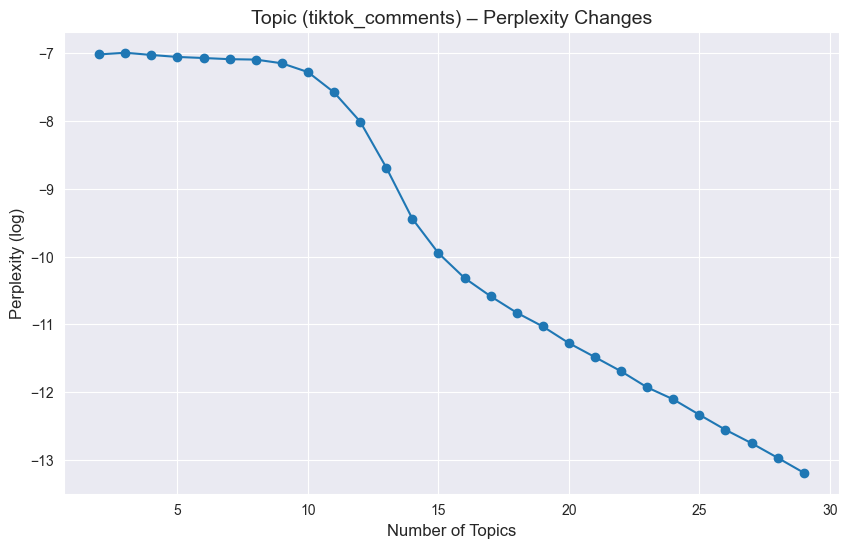

In [115]:
perplexities = []

for num_topics in tqdm(topic_range, desc="Evaluating topics"):
    lda_c = models.LdaModel(corpus=corpus_c, 
                   id2word=dictionary_c, 
                   num_topics=num_topics, 
                   random_state=42, 
                   passes=10, 
                   alpha='auto',
                   per_word_topics=True)
    
    log_perplexity_c = lda_c.log_perplexity(corpus_c)
    perplexities.append(log_perplexity_c)  # 注意：越接近 0 越好（负值）

# 画图
plt.figure(figsize=(10, 6))
plt.plot(topic_range, perplexities, marker='o')
plt.title("Topic (tiktok_comments) – Perplexity Changes", fontsize=14)
plt.xlabel("Number of Topics", fontsize=12)
plt.ylabel("Perplexity (log)", fontsize=12)
plt.grid(True)
plt.show()

In [117]:
num_topics = 6
# Train LDA
lda_model_c = models.LdaModel(
    corpus=corpus_c,
    id2word=dictionary_c,
    num_topics=num_topics,
    random_state=42,
    update_every=1,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

In [118]:
lda_model_c.print_topics(num_topics, num_words=15)

[(0,
  '0.044*"yes" + 0.034*"wait" + 0.025*"man" + 0.023*"yeah" + 0.019*"queen" + 0.017*"exactly" + 0.017*"beautiful" + 0.014*"eat" + 0.013*"miss" + 0.012*"happy" + 0.012*"woman" + 0.011*"sorry" + 0.011*"enjoy" + 0.011*"send" + 0.010*"que"'),
 (1,
  '0.097*"love" + 0.042*"good" + 0.033*"much" + 0.030*"day" + 0.027*"year" + 0.026*"real" + 0.024*"life" + 0.023*"every" + 0.018*"first" + 0.013*"stay" + 0.013*"new" + 0.013*"world" + 0.013*"art" + 0.012*"great" + 0.011*"dat"'),
 (2,
  '0.016*"friend" + 0.015*"bad" + 0.014*"call" + 0.014*"many" + 0.013*"create" + 0.013*"old" + 0.011*"god" + 0.011*"mama" + 0.011*"wish" + 0.011*"baby" + 0.011*"blonde" + 0.011*"mother" + 0.010*"kid" + 0.009*"fact" + 0.009*"favorite"'),
 (3,
  '0.061*"see" + 0.020*"head" + 0.018*"picture" + 0.015*"imagine" + 0.015*"aphantasia" + 0.015*"feel" + 0.014*"eye" + 0.014*"read" + 0.013*"make" + 0.012*"dream" + 0.012*"mind" + 0.012*"say" + 0.012*"time" + 0.011*"look" + 0.011*"apple"'),
 (4,
  '0.019*"die" + 0.018*"het" + 

In [119]:
# Visualize Topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model_c, corpus_c, dictionary_c)
pyLDAvis.display(vis)

# Save to html files
pyLDAvis.save_html(vis, "tiktok_6_c.html")

## BERTopic

In [11]:
video_texts_for_bertopic = (
    tiktok_videos_df["video_description_tokens"]
    .dropna()                        # 去掉 NaN
    .apply(lambda toks: " ".join(toks) if isinstance(toks, list) else str(toks))
    .tolist()                        # 转成 List[str]
)
comment_texts_for_bertopic = (
    tiktok_comments_df["comment_text_tokens"]
    .dropna()                        # 去掉 NaN
    .apply(lambda toks: " ".join(toks) if isinstance(toks, list) else str(toks))
    .tolist()                        # 转成 List[str]
)
print(len(video_texts_for_bertopic))
print(video_texts_for_bertopic[:3])
print(len(comment_texts_for_bertopic))
print(comment_texts_for_bertopic[:3])

2005
['put sleep dude', 'watch til end synesthesia aphantasia innermonologue', 'reply aphantasiamania autism disability parent kid']
65256
['make feature seem close middle face stab someone', 'eye crook goodnight', 'try put bed permanently']


In [14]:
all_tiktok_texts_bertopic = [" ".join(doc) for doc in tiktok_all_docs]
print(len(all_tiktok_texts_bertopic))
print(all_tiktok_texts_bertopic[:3])

67261
['put sleep dude', 'watch til end synesthesia aphantasia innermonologue', 'reply aphantasiamania autism disability parent kid']


### video description

In [15]:
# 1. 加载 BERT 嵌入模型
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
# reduce dimensionality
umap_model = UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine')
# Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=10, metric='euclidean', cluster_selection_method="eom", prediction_data=True)

# Create topic representation
vectorizer_model = CountVectorizer(
    # stop_words="english",
    ngram_range=(1, 2),
    min_df=5,                  # 至少在 5 篇文档出现
    max_df=0.4
)
ctfidf_model = ClassTfidfTransformer()

topic_model = BERTopic(
    embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    nr_topics='none',
    top_n_words = 10,
    calculate_probabilities=True, 
    verbose=True
)

# 3. 拟合文档
topics, probs = topic_model.fit_transform(video_texts_for_bertopic)

2025-08-31 10:38:37,275 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 63/63 [00:07<00:00,  8.38it/s]
2025-08-31 10:38:44,831 - BERTopic - Embedding - Completed ✓
2025-08-31 10:38:44,832 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
2025-08-31 10:38:52,773 - BERTopic - Dimensionality - Completed ✓
2025-08-31 10:38:52,774 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 10:38:52,952 - BERTopic - Cluster - Completed ✓
2025-08-31 10:38:52,953 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-08-31 10:38:53,033 - BERTopic - Representation - Completed ✓
2025-08-31 10:38:53,034 - BERTopic - Topic reduction - Reducing number of topics
2025-08-31 10:38:53,043 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 10:38:53,101 - BE

In [16]:
topic_model.visualize_topics()

In [17]:
topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,540,-1_image_meditation_something_experience,"[image, meditation, something, experience, app...",[space tear cry laughter keep come back let co...
1,0,164,0_book_read_author_character,"[book, read, author, character, bookish, serie...",[sooo taxis year bookshelf finally bunch new b...
2,1,133,1_neuroscience_consciousness_neurodiversity_ps...,"[neuroscience, consciousness, neurodiversity, ...",[academic snarky aphantasia neuroscience consc...
3,2,122,2_aphantasia aphantasia_jealous_one aphantasia...,"[aphantasia aphantasia, jealous, one aphantasi...","[aphantasia test curious, aphantasia mean see ..."
4,3,118,3_mental_imagery_image_apple,"[mental, imagery, image, apple, visual, inabil...",[aphantasia definition aphantasia inability vo...
5,4,100,4_guy_much_please_let,"[guy, much, please, let, miss, happy, end, mor...","[love guy, love guy, love guy much please let ..."
6,5,62,5_hyperphantasia_song_music_new,"[hyperphantasia, song, music, new, come, thank...",[wonderful bday listen new song hyperphantasia...
7,6,58,6_neurodivergent_adhd_audhd_actuallyautistic,"[neurodivergent, adhd, audhd, actuallyautistic...",[reply algorithmtestpilot drop question commen...
8,7,48,7_artist_aphantasia artist_artist aphantasia_a...,"[artist, aphantasia artist, artist aphantasia,...","[reaction aphantasia artist, bleh artist aphan..."
9,8,48,8_please_wait_right_yeah,"[please, wait, right, yeah, hey, ready, confus...","[please beg, please merthy, please]"


In [165]:
from gensim.corpora import Dictionary
from gensim.models.coherencemodel import CoherenceModel

# 1. 取出主题和词
topics = topic_model.get_topics()   # {topic_id: [(word, weight), ...]}
top_words = [[word for word, _ in topics[topic_id]] for topic_id in topics.keys() if topic_id != -1]

# 2. 准备语料和字典
texts = [doc.split() for doc in video_texts_for_bertopic]  # 已经分词的文本
dictionary = Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

# 3. 计算coherence
coherence_model = CoherenceModel(
    topics=top_words, 
    texts=texts, 
    dictionary=dictionary, 
    coherence='c_v'   # 常用: 'u_mass', 'c_v', 'c_uci', 'c_npmi'
)
coherence_score = coherence_model.get_coherence()
print("Coherence Score:", coherence_score)


/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead

/Users/jinzi/miniconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning:

ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead

/Users/jinzi/miniconda3/lib/python3.12/ast.py:587: DeprecationWarning:

Attribute s is deprecated and will be removed in Python 3.14; use value instead



AttributeError: 'NoneType' object has no attribute 'keys'

### comments

In [18]:
import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"
# reduce dimensionality
umap_model = UMAP(n_neighbors=30, n_components=5, min_dist=0.1, metric='cosine')
# Cluster reduced embeddings
hdbscan_model = HDBSCAN(min_cluster_size=30, metric='euclidean', cluster_selection_method="eom", prediction_data=True)

# Create topic representation
vectorizer_model = CountVectorizer(
    # stop_words="english",
    ngram_range=(1, 2),
    min_df=5,                  # 至少在 5 篇文档出现
    max_df=0.7
)
ctfidf_model = ClassTfidfTransformer()

c_topic_model = BERTopic(
    embedding_model=embedding_model,    # Step 1 - Extract embeddings
    umap_model=umap_model,              # Step 2 - Reduce dimensionality
    hdbscan_model=hdbscan_model,        # Step 3 - Cluster reduced embeddings
    vectorizer_model=vectorizer_model,  # Step 4 - Tokenize topics
    ctfidf_model=ctfidf_model,          # Step 5 - Extract topic words
    nr_topics='none',
    top_n_words = 10,
    calculate_probabilities=True, 
    verbose=True
)

# 3. 拟合文档
c_topics, c_probs = c_topic_model.fit_transform(comment_texts_for_bertopic)

2025-08-31 13:10:09,385 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 2040/2040 [00:38<00:00, 53.57it/s] 
2025-08-31 13:10:47,800 - BERTopic - Embedding - Completed ✓
2025-08-31 13:10:47,800 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-08-31 13:11:11,687 - BERTopic - Dimensionality - Completed ✓
2025-08-31 13:11:11,688 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-08-31 13:14:59,058 - BERTopic - Cluster - Completed ✓
2025-08-31 13:14:59,061 - BERTopic - Representation - Extracting topics using c-TF-IDF for topic reduction.
2025-08-31 13:14:59,460 - BERTopic - Representation - Completed ✓
2025-08-31 13:14:59,460 - BERTopic - Topic reduction - Reducing number of topics
2025-08-31 13:14:59,540 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-08-31 13:14:59,838 - BERTopic - Representation - Completed ✓
2025-08-31 13:14:59,841 - BERTopic - Topic reduction -

In [19]:
c_topic_model.visualize_topics()

In [20]:
c_topic_model.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,25565,-1_eye_see_mind_hear,"[eye, see, mind, hear, picture, image, voice, ...","[listen talk sound yes, wild actually see char..."
1,0,5839,0_rite_therefore_notice_dat,"[rite, therefore, notice, dat, instead, , , , , ]","[, , ]"
2,1,3093,1_non_die_film_ben,"[non, die, film, ben, per, dat, bende, dan, ma...",[non riesco neppure immaginare vagamente perso...
3,2,2541,2_dream_aphantasia_nightmare_vivid,"[dream, aphantasia, nightmare, vivid, vivid dr...","[apkatasia dream, antaphasia dream, aphantasia..."
4,3,2325,3_movie_book_read_movie head,"[movie, book, read, movie head, read book, wat...","[see movie head read book, read book watch mov..."
...,...,...,...,...,...
222,221,32,221_silent_silent brain_quiet_quiet brain,"[silent, silent brain, quiet, quiet brain, bra...","[wish silent brain, imagine silent brain, sile..."
223,222,31,222_spotify_playlist_please need_edit,"[spotify, playlist, please need, edit, put, pl...","[spotify, spotify, spotify]"
224,223,31,223_sister_brother_heart_content,"[sister, brother, heart, content, hear somewhe...","[sister, sister, sister]"
225,224,31,224_sleep_fall asleep_asleep_noise,"[sleep, fall asleep, asleep, noise, fall, musi...",[sleep rain sound white noise sleep night musi...


# sentiment analysis

## RoBERTa

In [121]:
from transformers import pipeline

In [122]:
# 加载 HuggingFace 上的 RoBERTa 情感分析模型
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="cardiffnlp/twitter-roberta-base-sentiment",
    tokenizer="cardiffnlp/twitter-roberta-base-sentiment",
    truncation=True,
    max_length=128
)

In [123]:
batch_size = 128
roberta_sentiments = []
roberta_scores = []
tiktok_comment_texts = tiktok_comments_df["text"].tolist()

for i in tqdm(range(0, len(tiktok_comment_texts), batch_size), desc="Processing Sentiment"):
    batch = tiktok_comment_texts[i:i+batch_size]
    try:
        result = sentiment_pipeline(
            batch,
            truncation=True,      # ← 放这里
            padding=True,         # ← 放这里
            max_length=128        # 128/256 通常足够，远快于 512
        )
        roberta_sentiments += [r["label"] for r in result]
        roberta_scores += [r["score"] for r in result]
    except Exception as e:
        print(f"Batch {i}-{i+batch_size} failed: {e}")
        roberta_sentiments += ["ERROR"] * len(batch)
        roberta_scores += [0.0] * len(batch)

Processing Sentiment: 100%|██████████| 510/510 [32:57<00:00,  3.88s/it]


In [124]:
tiktok_comments_df["roberta_sentiment"] = roberta_sentiments
tiktok_comments_df["roberta_score"] = roberta_scores

In [126]:
label_map = {"LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2": "positive"}
tiktok_comments_df["roberta_label"] = tiktok_comments_df["roberta_sentiment"].map(label_map)

In [127]:
def calc_polarity(label, score):
    if label == "positive":
        return score
    elif label == "negative":
        return -score
    else:  # neutral
        return 0.0

tiktok_comments_df["roberta_polarity"] = [
    calc_polarity(lab, sc) for lab, sc in zip(tiktok_comments_df["roberta_label"], tiktok_comments_df["roberta_score"])
]

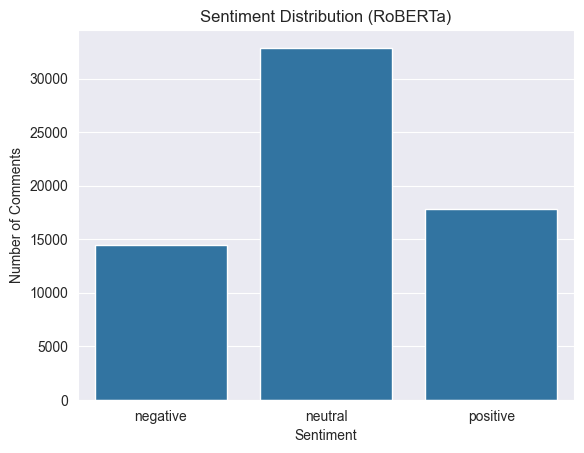

In [128]:
# 柱状图统计情绪分布
sns.countplot(data=tiktok_comments_df, x="roberta_label", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution (RoBERTa)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

## VADER


In [129]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [130]:
analyzer = SentimentIntensityAnalyzer()

In [131]:
def get_vader_scores(text):
    vader_scores = analyzer.polarity_scores(text)
    return pd.Series([vader_scores["compound"], vader_scores["pos"], vader_scores["neu"], vader_scores["neg"]])

In [134]:
tiktok_comments_df[["vader_compound", "vader_pos", "vader_neu", "vader_neg"]] = tiktok_comments_df["text"].apply(get_vader_scores)

In [135]:
def vader_label(vader_scores):
    if vader_scores >= 0.05:
        return "positive"
    elif vader_scores <= -0.05:
        return "negative"
    else:
        return "neutral"

tiktok_comments_df["vader_label"] = tiktok_comments_df["vader_compound"].apply(vader_label)

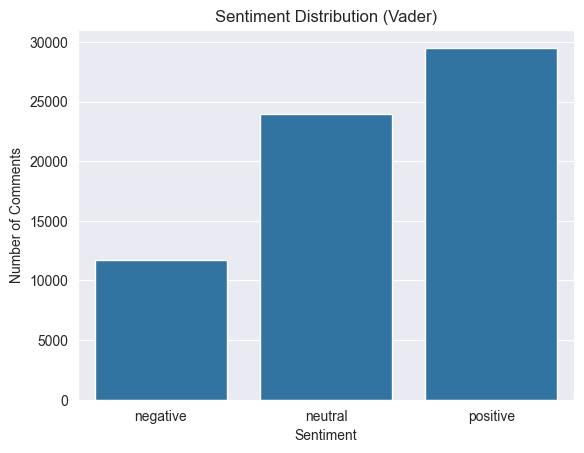

In [136]:
sns.countplot(data=tiktok_comments_df, x="vader_label", order=["negative", "neutral", "positive"])
plt.title("Sentiment Distribution (Vader)")
plt.xlabel("Sentiment")
plt.ylabel("Number of Comments")
plt.show()

In [138]:
# 对 comment_body 每条文本算 VADER polarity
tiktok_comments_df["vader_polarity"] = tiktok_comments_df["text"].astype(str).apply(
    lambda x: analyzer.polarity_scores(x)["compound"]
)

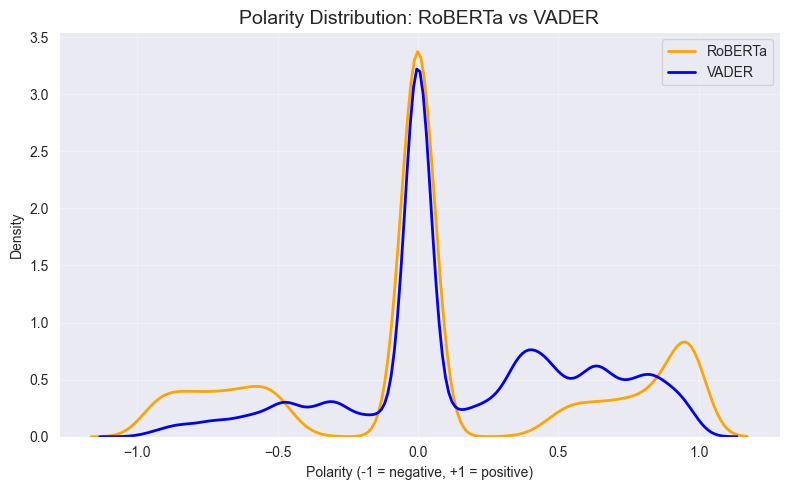

In [139]:
plt.figure(figsize=(8,5))

sns.kdeplot(tiktok_comments_df["roberta_polarity"], label="RoBERTa", color="orange", linewidth=2)
sns.kdeplot(tiktok_comments_df["vader_polarity"],   label="VADER",   color="blue", linewidth=2)

plt.title("Polarity Distribution: RoBERTa vs VADER", fontsize=14)
plt.xlabel("Polarity (-1 = negative, +1 = positive)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## Extremely emotion topic modeling

In [142]:
disagree_df = tiktok_comments_df[
    (tiktok_comments_df["roberta_label"] == "positive") & 
    (tiktok_comments_df["vader_label"] == "negative")
]

disagree_df[["text", "roberta_score", "vader_compound"]].head()

,text,roberta_score,vader_compound
53,It did the same thing to my face too it’s okay 😭,0.519964,-0.2960
132,Why you’re so cuteeee❤️😭,0.977575,-0.4767
144,I know it made y’all feel bad but it actually ...,0.799775,-0.7506
163,it feels so nice i can have a conversation in ...,0.978731,-0.1239
179,"sometimes I think God is speaking to me, norma...",0.549313,-0.4310


In [143]:
# 筛选一致的样本
agreed_df = tiktok_comments_df[tiktok_comments_df["roberta_label"] == tiktok_comments_df["vader_label"]].copy()

In [144]:
top_5_df = agreed_df.sort_values("vader_compound", ascending=False).head(int(len(agreed_df) * 0.05))
bottom_5_df = agreed_df.sort_values("vader_compound", ascending=True).head(int(len(agreed_df) * 0.05))

In [ ]:
top_5_df

In [ ]:
bottom_5_df

In [145]:
custom_stopwords = {"t", "ve", "re", "d", "m", "ll", "s", "I",
                    "also", "would", "think", "people", "get", "go", "like", "just", "know", "thing", "things", "really"}
stop_words = set(stopwords.words('english')).union(custom_stopwords)

In [147]:
# 2. 对子集分别进行 stopwords 清洗
def remove_stopwords(text):
    return " ".join([word for word in text.split() if word not in stop_words])

top_5_df["text_clean"] = top_5_df["text"].apply(remove_stopwords)
bottom_5_df["text_clean"] = bottom_5_df["text"].apply(remove_stopwords)

# 3. 用 clean 文本建 BERTopic
top_texts = top_5_df["text_clean"].dropna().tolist()
bottom_texts = bottom_5_df["text_clean"].dropna().tolist()

# 构造 vectorizer（再传入 BERTopic）
vectorizer_model = CountVectorizer(stop_words='english')
topic_model_top = BERTopic(vectorizer_model=vectorizer_model)
topic_model_bottom = BERTopic(vectorizer_model=vectorizer_model)

# 主题建模
topics_top, _ = topic_model_top.fit_transform(top_texts)
topics_bottom, _ = topic_model_bottom.fit_transform(bottom_texts)

In [148]:
top_vis = topic_model_top.visualize_topics()
top_vis

In [149]:
topic_model_top.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,543,-1_love_im_yes_beautiful,"[love, im, yes, beautiful, good, thank, feel, ...","[beautiful. thank much sharing us 🥰, love this..."
1,0,482,0_ily_wow_hermosa_makin,"[ily, wow, hermosa, makin, ilysm, hahhah, jojo...","[ily🖤👏👏👏🖤, 🥰🥰🥰 ILY, brows purrrrfect😫✨🥰🥰🥰]"
2,1,115,1_voice_song_sing_sound,"[voice, song, sing, sound, beautiful, listen, ...","[Your voice 🥰🥰, ♥️I love voice ♥️, love voice 🥰]"
3,2,110,2_happy_sending_anniversary_family,"[happy, sending, anniversary, family, hope, lo...","[🥰🥰🥰🥰🥰🥰🥰🥰 Happy Anniversary Mom & Dad, absolut..."
4,3,84,3_baby_mama_mom_happy,"[baby, mama, mom, happy, mother, birthday, lov...",[love much love mom 🥺 everyone baby deserve mo...
5,4,80,4_reading_movie_read_book,"[reading, movie, read, book, head, books, watc...","[love reading books, watching movie fr 🥰, movi..."
6,5,58,5_beautiful_thank_cute_wow,"[beautiful, thank, cute, wow, amazing, awesome...","[🥰 beautiful ❤️, beautiful 💕💕💕💕🔥🔥👑, Beautiful 🥰🥰]"
7,6,47,6_love_fucking_respect_freaking,"[love, fucking, respect, freaking, adore, rn, ...","[love 😂😂😂, love 🤣💜, love much🥰]"
8,7,44,7_dreams_remember_dream_memory,"[dreams, remember, dream, memory, vivid, memor...","[dream vividly details, aphantasia. Dreams sup..."
9,8,29,8_videos_video_just_love,"[videos, video, just, love, account, sooo, sta...","[YES best video I've seen day♥️😂, These favori..."


In [150]:
bottom_vis = topic_model_bottom.visualize_topics()
bottom_vis

In [151]:
topic_model_bottom.get_topic_info()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,628,-1_im_bad_head_feel,"[im, bad, head, feel, thought, dont, mind, pic...",[Omg!! This make sense could never reading. th...
1,0,193,0_angry_man_mom_baby,"[angry, man, mom, baby, house, kids, parents, ...","[Shit. I’m angry man house., became angry man ..."
2,1,158,1_fr_boobie_henry_boyleyim,"[fr, boobie, henry, boyleyim, angeles, accentl...","[Los Angeles 😢😢🥺, FREE LUIGI 😭😭😭😭😭, Lmfaoooooo..."
3,2,85,2_bad_sad_crying_unimpressed,"[bad, sad, crying, unimpressed, hell, im, feel...","[Sad unimpressed broke :(, SAD 🔥 unimpressed 😑..."
4,3,75,3_reading_read_movie_book,"[reading, read, movie, book, books, words, bor...",[That’s terrible omg😭 u read book? visualize e...
5,4,71,4_dialogue_opposite_writing_write,"[dialogue, opposite, writing, write, dialouge,...",[exact opposite problem suck writing dialogue ...
6,5,54,5_aphantasia_jealous_draw_artist,"[aphantasia, jealous, draw, artist, hate, wors...","[I'm jealous aphantasia 😭, aphantasia 😭😭, Same..."
7,6,51,6_song_singing_sound_vocals,"[song, singing, sound, vocals, voice, music, h...",[okay basically....if ever heard song NOT soun...
8,7,49,7_monologue_inner_internal_head,"[monologue, inner, internal, head, voice, thou...",[yeah trying explain lack visualization inner ...
9,8,40,8_draw_drawing_art_reference,"[draw, drawing, art, reference, animate, anima...",[draw CANNOT animate shit it’s upsetting I’m b...


In [153]:
topic_model_bottom.get_topic_info(2)

,Topic,Count,Name,Representation,Representative_Docs
0,2,85,2_bad_sad_crying_unimpressed,"[bad, sad, crying, unimpressed, hell, im, feel...","[Sad unimpressed broke :(, SAD 🔥 unimpressed 😑..."


## semantic similarity and emotion result

In [155]:
from sentence_transformers import SentenceTransformer, util
from sklearn.metrics.pairwise import cosine_similarity
model = SentenceTransformer("all-MiniLM-L6-v2")

semantic_queries = [
    "I didn't know aphantasia existed",
    "I can't imagine not having mental images",
    "That’s crazy you can’t see pictures in your head",
    "I always thought everyone could visualize",
    "It’s fascinating that some people can’t imagine things",
    "I feel bad for people who can't picture things",
]

comments_texts = tiktok_comments_df["text"].fillna("").tolist()
# 3. 文本嵌入
comment_embeddings = model.encode(comments_texts, convert_to_tensor=True)
query_embeddings = model.encode(semantic_queries, convert_to_tensor=True)

# 4. 计算相似度
similarities = cosine_similarity(query_embeddings.cpu().numpy(), comment_embeddings.cpu().numpy())


In [156]:
# 5. 获取最相似的 top-N
top_n = 30  # 你想看前30个最相关的

# 为每个 query 提取 top_n
top_matches = []
for i, sim_scores in enumerate(similarities):
    top_indices = np.argsort(sim_scores)[::-1][:top_n]
    for idx in top_indices:
        top_matches.append({
            "query": semantic_queries[i],
            "score": sim_scores[idx],
            "comments_texts": comments_texts[idx]
        })

# 转为 DataFrame 方便查看
import pandas as pd
top_matches_df = pd.DataFrame(top_matches).sort_values(by="score", ascending=False).drop_duplicates("comments_texts")

In [157]:
texts_for_goemotions = top_matches_df["comments_texts"].dropna().tolist()

In [158]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.nn.functional import sigmoid

# 模型 & 标签（你已有）
model = AutoModelForSequenceClassification.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
tokenizer = AutoTokenizer.from_pretrained("joeddav/distilbert-base-uncased-go-emotions-student")
labels = ['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity',
          'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear',
          'gratitude', 'grief', 'joy', 'love', 'nervousness', 'neutral', 'optimism', 'pride', 'realization',
          'relief', 'remorse', 'sadness', 'surprise']

In [159]:
# 文本
inputs = tokenizer(texts_for_goemotions , padding=True, truncation=True, return_tensors="pt")
with torch.no_grad():
    logits = model(**inputs).logits
probs = sigmoid(logits)

In [160]:
# 阈值
threshold = 0.7
emotion_results = []
for i, prob in enumerate(probs):
    emotions = [labels[j] for j, p in enumerate(prob) if p > threshold]
    emotion_results.append({
        "text": texts_for_goemotions[i],
        "emotions": emotions
    })

In [161]:
emotion_df = pd.DataFrame(emotion_results)

In [164]:
emotion_df

,text,emotions
0,I never realized everyone couldn’t visualize,"[confusion, sadness]"
1,Aphantasia here,[remorse]
2,I had never heard of aphantasia before!,"[curiosity, excitement, pride, sadness]"
3,aphantasia,[]
4,aphantasia?,"[confusion, curiosity]"
...,...,...
154,i would GIVE ANYTHING TO BE ABLE TO PICTURE ST...,"[anger, annoyance, disappointment, disapproval..."
155,As someone who is a large picture thinker and ...,"[disappointment, embarrassment, relief, remorse]"
156,I don’t understand- anytime I want to picture ...,"[confusion, curiosity, desire]"
157,i can picture thing just not be crietive about it,[annoyance]


In [162]:
# 展平所有标签为一个 list
all_emotions = [emotion for sublist in emotion_df['emotions'] for emotion in sublist]

# 统计每个情绪的频率
emotion_counts = Counter(all_emotions)
emotion_series = pd.Series(emotion_counts).sort_values(ascending=False)

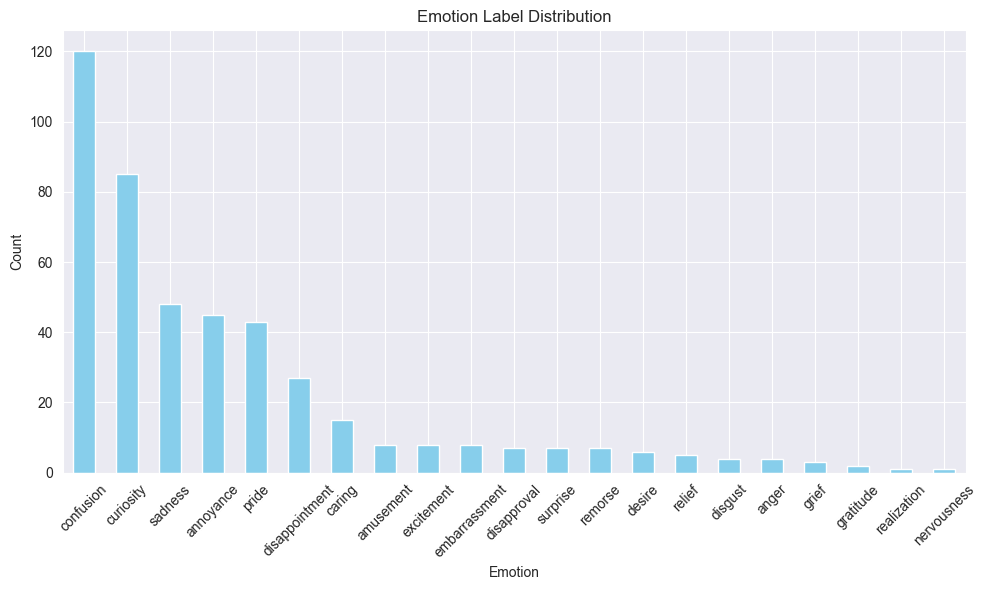

In [163]:
plt.figure(figsize=(10, 6))
emotion_series.plot(kind="bar", color="skyblue")
plt.title("Emotion Label Distribution")
plt.ylabel("Count")
plt.xlabel("Emotion")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
########